# 1. Introdução

Neste projeto, vamos fazer uma análise da PETR4. O desenvolvimento da análise parassará pelas etapas principais de estudo para entendermos mais sobre o ativo em questão.

- Inicialmente, irei desenvolver uma análise descritiva do ativo, tentando entender de forma mais aprofundada a evolução dos preços (cotações) e dos retornos, passando pelo histograma da distribuição de retornos.

- Em seguida, irei desenvolver o entendimento da distribuição dos retornos, tentando entender a assimetria, curtose e normalidade da amostra. Esses efeitos devem nos dar alguns vislubres e insights sobre o ativo que estamos estudando e também devem criar uma base para entendermos qual o nosso risco e nossa perda potencial, baseando-nos no Value-at-Risk (VaR).

- Por fim, vamos analisar os principais indicadores quantitativos, tais como os índices de Sharpe, Sortino e Calmar, que nos ajudarão a entender se o investimento em PETR4 é atrativo ou não, de acordo com a Selic (definida em 8% a.a.)

# 2. Importando Bibliotecas e Dados

## 2.1. Importando Bibliotecas

In [1]:
import pandas as pd
import yfinance as yf
from scipy.stats import skew, kurtosis, shapiro, norm
from scipy import stats
import pylab
import numpy as np

## 2.2. Importando Dados

Vou iniciar minha análise utilizando a biblioteca do Yahoo Finance para puxar os dados de PETR4. Para a análise em questão, irei trabalhar com dados diários entre 01/01/2020 e 01/09/2023. O arquivo com os dados diários utilizados também será disponibilizado para futuros usos, caso haja a necessidade.

In [2]:
petr4 = yf.download('PETR4.SA', start= '2020-01-01', end= '2023-09-01')[['Close', 'Adj Close']]
petr4.head()

[*********************100%***********************]  1 of 1 completed


,Close,Adj Close
Date,,
2020-01-02,30.700001,11.732863
2020-01-03,30.450001,11.637318
2020-01-06,30.809999,11.774903
2020-01-07,30.690001,11.729042
2020-01-08,30.500000,11.656427


# 3. Iniciando Análise Descritiva

## 3.1. Cotações de PETR4

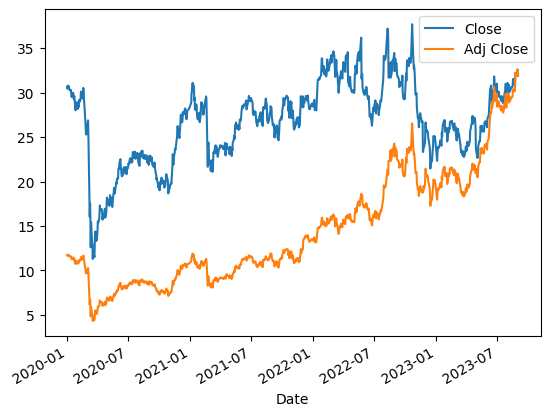

In [3]:
petr4.plot();

O gráfico de preço mostra que o ativo vem apresentando uma tendência ascendente. Também conseguimos ver que o preço mínimo ocorreu ali por volta do início de 2020, o que parece ter sido drivado pela pandemia do COVID-19.

Utilizarei o preço de fechamento ajustado em algumas análises para evitar distorções no dado, visto que estou usando informação desde 2020. Para mais contexto, o preço de fechamento ajustado é basicamente o preço de fechmento do ativo, porém é levado em consideração o pagamento de dividendos e os dedobramentos no período.

Vou seguir calculando os principais indicadores estatísticos dessa amostra para termos um melhor entendimento de nossos dados.

In [4]:
petr4.describe()

,Close,Adj Close
count,913.000000,913.000000
mean,26.716670,14.662244
std,4.581068,6.404136
min,11.290000,4.314788
25%,23.620001,9.457971
50%,27.150000,11.930101
75%,29.809999,19.394045
max,37.720001,32.619999


Pontos importantes identificados à partir do preço de fechamento ("Close"):
- Aqui vemos 913 entradas de dado, no qual o preço médio foi de R$ 26,71.
- O valor foi de um mínimo de R$ 11,29 para um máximo de R$ 37,72, ou seja, uma amplitude de R$ 26,43.
- Vemos o desvio padrão da média (ou seja, a volatilidade doa ativo) em aproximadamente R$ 4,58.

Para seguir com o estudo, agora irei me focar no preço de fechamento ajustado.

## 3.2. Análise dos Retornos

In [5]:
petr4_adj = petr4['Adj Close']
petr4_adj = petr4_adj.to_frame()
petr4_adj.head()

,Adj Close
Date,
2020-01-02,11.732863
2020-01-03,11.637318
2020-01-06,11.774903
2020-01-07,11.729042
2020-01-08,11.656427


Agora, irei trazer o retorno diário, considerando a evolução dos preços dia a dia.

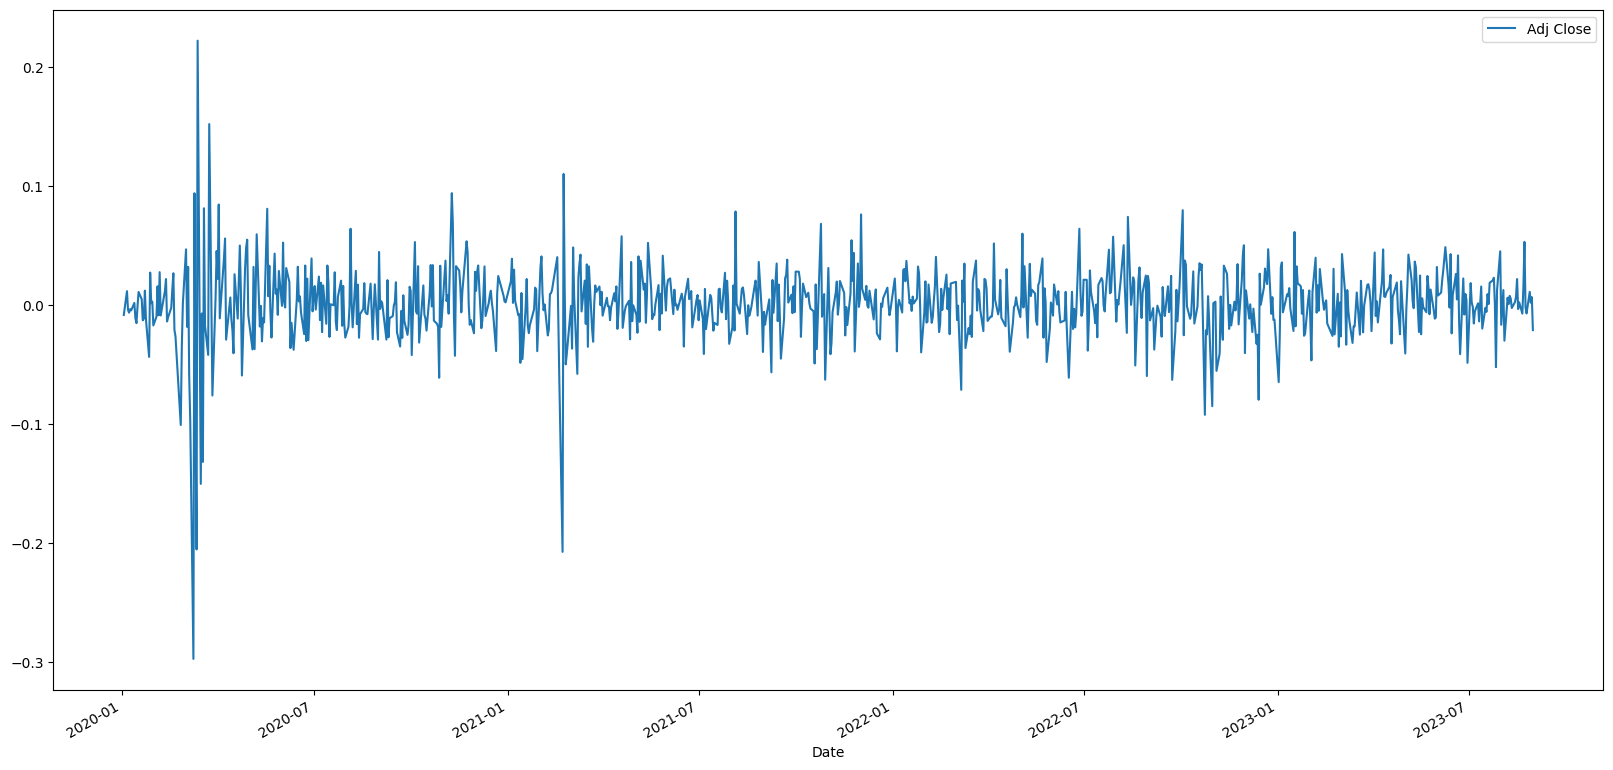

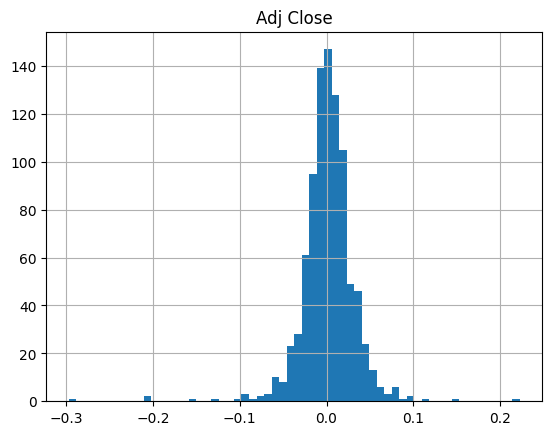

In [6]:
petr4_adj_retorno = petr4_adj.pct_change()
petr4_adj_retorno = petr4_adj_retorno.dropna()
petr4_adj_retorno.plot(figsize= (20,10));
petr4_adj_retorno.hist(bins= 60);

Pelos gráficos acima, podemos ter um vislubre sobre os retornos de PETR4 no período:
1. Os retornos parecem ter uma característica de estacionária, como é esperado, apresentando a regressão do valor a uma espécie de "média".
2. A distribuição de retronos parece se assemelhar a uma distribuição normal, tendendo a respeitar na maior parte dos dias os valores de retorno entre -0,1% e 0,1%.

Seguindo agora para as métricas descritivas dos retornos.

In [7]:
petr4_adj_retorno.describe()

,Adj Close
count,912.000000
mean,0.001603
std,0.031220
min,-0.296978
25%,-0.012513
50%,0.001459
75%,0.016827
max,0.222222


A descrição dos retornos mostra a média próxima a zero (corroborando o histograma anterior), um desvio padrão de 0,03% e uma amplitude de 0,51.

Por fim, irei gráficar o retorno acumulado desse ativo no período:

In [8]:
petr4_adj_retorno_acum = (1+petr4_adj_retorno).cumprod()
petr4_adj_retorno_acum.iloc[-1][0]*100


272.2268160278003

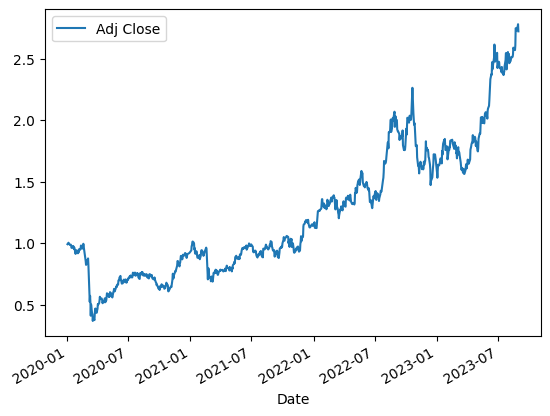

In [9]:
petr4_adj_retorno_acum.plot();

Vemos portanto uma rentabilidade de 272% no período, considerando o preço de fechamento ajustado.

# 4. Simetria e Normalidade

## 4.1. Skewness

Vamos agora olhar para a assimetria (skewness) e para a curtose (kurtosis) do nosso histograma e, em seguida, faremos um teste de normalidade para entendermos se estamos olhando para uma distribuição normal.

Idealmente, quando falamos de Skewness, vamos querer analisar a média e a mediana dos ativos.

- Se $Média = Mediana$, então dizemos que a distribuição é simétrica e sua sietria se assemelha à de uma distribuição normal.
- Se $Média > Mediana$, então dizemos que a distribuição tem assimetria positiva (right-skewed).
- Se $Média < Mediana$, então dizemos que a distribuição tem assimetria negativa (left-skewed).

Para o ativo ideal, buscamos uma assimetria negativa, afinal esse tipo de distribuição indica que teríamos pequenos ganhos com maior frequência e grandes perdas com menor frequência.

Se olharmos para a descrição dos retornos, temos que a média da nossa distribuição de retornos é de 0,001603 e que a mediana é 0,001459 (mediana é o 50%). Por esse fato, já devemos entender, por conta do conceito de skewness que estamos lidando com uma assimetria negativa. Portanto, vamos calcular essa assimetria:

In [10]:
skewness = skew(petr4_adj_retorno)
skewness

array([-1.26237541])

Como esperado, temos uma assimetria de aproximadamente -1,26. Isso pode ser um indicativo de que estamos olhandopara um ativo interessante, visto que ele nos traz pequenos ganhos com mais frequência.

## 4.2. Kurtosis

Agora, vamos seguir tentando fazer a descrição de nossos retornos. Vamos olhar para a Curtose (Kurtosis).
Quando falamos de curtose na estatística descrivia, basicamente estamos estudando a medida que caracteriza o achatamento da curva em uma distribuição de probabilidade.

- Se $Curtose = 0$, então a curva tem o mesmo achatamento de uma distribuição normal.
- Se $Curtose > 0$, então a curva é mais alta (mais afunilada) e concentrada do que uma distribuição normal.
- Se $Curtose < 0$, então a curva é mais achatada do que uma distribuição normal.

In [11]:
curtose = kurtosis(petr4_adj_retorno)
curtose

array([17.00100275])

No nosso caso, estamos vendo uma curtose positiva, o que indica que temos uma distribuição mais alta e concentrada. Esse resultado também corrobora com o histograma montado anteriormente.

## 4.3. Teste de Normalidade Shapiro-Wik

Para determinarmos se uma distribuição é normal ou não, é preciso verificar se essa distribuição segue a função de densidade de probabilidade que, por sua vez, é uma equação que representa a distribuição de probabilidade de uma variável aleatória e contínua, sendo definida da seguinte maneira:

\begin{equation}
f(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}
\end{equation}

Em distribuições não normais, $E[X]=\mu$, com E[X] sendo o valor esperado, que será a média.
Além disso, $V(X)=\sigma^2$, com V(X) sendo a variância.

Já em distribuições normais, $\mu = 0$ e $\sigma = 1$, de forma que a equação se torna:

\begin{equation}
f(x)=\frac{1}{\sqrt{2\pi}}e^{-{x^2}/{2}}
\end{equation}

In [12]:
shapiro_petr4 = shapiro(petr4_adj_retorno)
shapiro_petr4

ShapiroResult(statistic=0.8603799343109131, pvalue=1.1056711810618623e-27)

Como o teste de nromalidade Shapiro-Wik possui um p-valor menor que 0,05, então podemos dizer que nossa distribuição não é normal.

Por fim, vou graficar um comparativo dos meus retornos com uma distribuição normal. Isso deve mostrar de forma mais gráfica os resultados que atingimos em todos as validações anteriores.

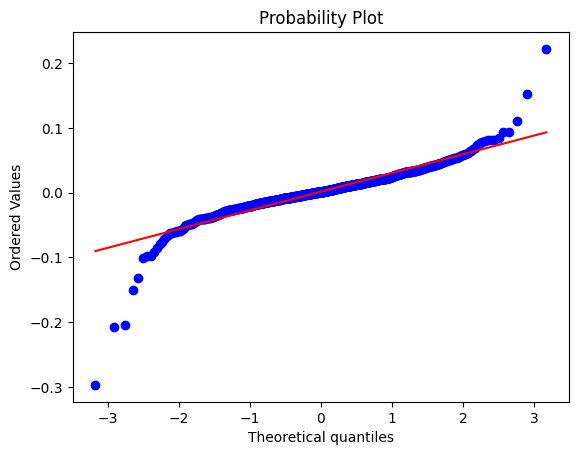

In [13]:
stats.probplot(petr4_adj_retorno['Adj Close'], dist='norm', plot=pylab)
pylab.show()

Caso estivessemos com uma distribuiçao normal, teríamos os pontos azuis sobreponto a linha vermelha, contudo é possível ver alguns outliers. Esse tipo de comportamento é esperado no mercado financeiro, uma vez que existem muito eventos externos que podem influenciar os retornos, gerando comportamentos que escapam do esperado em uma distribuição normal.

Esses comportamentos, muitas vezes são conhecidos como "eventos de risco de cauda" ou os próprios "cisnes negros".

## 4.4. Value-at-Risk

O próximo passo agora será avaliar o risco desse ativo através do Value-at-Risk (VaR). De maneira pragmática, o VaR calcula a perda potencial do investimento dado um certo intervalo de confiança.

Para nosso estudo, irei utilizar o VaR em três intervalos de confiança:

- 90%
- 95%
- 99%

Desse modo, poderemos ter um melhor entendimento do risco que estamos correndo.
Lembrando que essa é apenas uma inferência estatística, olhando para dados histórico, ou seja, o VaR não será 100% exato e não deve ser usado como fator exclusivo de definição de risco. Além disso, como vimos anteriormente, nossa amostra não apresneta uma distribuição 100% normal, o que pode enviesar o resultado.

### 4.4.1. VaR Histórico

Inicialmente irei calcular o VaR histórico, ou seja, irei olhar para os dados históricos e retirar qual as probabilidades de perda nos intervalos de confiança estipulados anteriormente. Para isso, quebrarei a distribuição (idealmente, deve ser uma distribuição normal) nos quartis de 10% (para o VaR 90%) de 5% (para o VaR 95%) e de 1% (para o VaR 99%).

In [14]:
var_90 = np.nanpercentile(petr4_adj_retorno,10)
var_95 = np.nanpercentile(petr4_adj_retorno,5)
var_99 = np.nanpercentile(petr4_adj_retorno,1)

In [15]:
print(f'VaR 90% = {var_90}\n'
      f'VaR 95% = {var_95}\n'
      f'VaR 99% = {var_99}\n')

VaR 90% = -0.02716208639410511
VaR 95% = -0.04020617379953999
VaR 99% = -0.0841454924870736



Com os resultados acima obtidas pelo histórico dos dois últimos anos, podemos tirar as seguintes conclusões:

1. Existe menos de 10% de chance de ocorrer uma perda diária de mais de 2,7%.
2. Existe menos de 5% de chance de ocorrer uma perda diária de mais de 4,0%.
3. Existe menos de 1% de chance de ocorrer uma perda diária de mais de 8,4%.

### 4.4.2. VaR Paramétrico

Para o VaR Paramétrico, irei utilizar uma distribuição normal e passarei os parâmetros encontrados para calcular o VaR.

In [16]:
media_amostra = np.mean(petr4_adj_retorno)
std_amostra = np.std(petr4_adj_retorno)

In [17]:
var_90_param = norm.ppf(1-0.9, media_amostra,std_amostra)
var_95_param = norm.ppf(1-0.95, media_amostra,std_amostra)
var_99_param = norm.ppf(1-0.99, media_amostra,std_amostra)

In [18]:
print(f'VaR Parametrico 90% = {var_90_param}\n'
      f'VaR Parametrico 95% = {var_95_param}\n'
      f'VaR Parametrico 99% = {var_99_param}\n')

VaR Parametrico 90% = [-0.03838543]
VaR Parametrico 95% = [-0.04972156]
VaR Parametrico 99% = [-0.07098626]



Com os resultados acima obtidas pelo VaR Paramétrico dos dois últimos anos, podemos entender que:

1. Existe menos de 10% de chance de ocorrer uma perda diária de mais de 3,8%.
2. Existe menos de 5% de chance de ocorrer uma perda diária de mais de 4,9%.
3. Existe menos de 1% de chance de ocorrer uma perda diária de mais de 7,0%.

Um ponto importante aqui é que o VaR Paramétrico e o Histórico são calculados de formas diferentes, ou seja, podem apresentar diferenças entre eles.
O VaR paramétrico, no caso acima, está assumindo de forma intrínseca que nossa distribuição é normal, portanto é natural que encontra informações diferentes do histórico, visto que já analisaos que nossa distribuição não é normal.

Um ponto interessante do VaR paramétrico é que se quisermos, podemos estimar uma média de retorno da forma que acharmos mais convencional e utilizar para tentar projetar pontos futuros. É obvio que essa abordagem gera distorções por conta do elevado grau de dificuldade de predizer de forma aceitável a média de retornos e desvio padrão de pontos futuros, mas a técnica pode ser utilizada como uma projeção.

# 5. Análise Quantitativa

Agora que temos todo o desenvolvimento de nossa análise descritiva e entendemos a distribuição de probabilidades dos retornos da amostra não é normal, sigo avançando para começarmos a entender alguns índices quantitativos.

Iremos fazer as seguintes análises:

- Índice de Sharpe;
- Índice de Sortino;
- Drawdown;
- Índice de Calmar.

## 5.1. Índice de Sharpe

O índice de sharpe irá buscar a comparação relativa entre o risco e retorno do nosso ativo escolhido (PETR4) e um investimento livre de risco, que no caso iremos utilizar a SELIC. Para se calcular esse índice, é necessário utilizar a seguinte equação:

\begin{equation}
Sharpe=\frac{({R_i} - {R_f})}{\sigma_i}
\end{equation}

Na qual $R_i$ é o retorno do investimento, $R_f$ é retorno livre de risco e $\sigma_i$ é o risco (a volatilidade) do ativo.

Para efeitos de cálculo, utilizarei a Selic com o valor de 8% a.a.

In [19]:
selic = 0.08

Agora, para calcular o retorno desse investimeo, será preciso trazer o retorno médio diário, o desvio padrão (volatilidade) e anualizar esses valores, multiplicando a média por 252 (o número aproximado de dias úteis em um ano), assim poderei comparar com a Selic que também está anualizada.

In [20]:
petr4_adj_retorno_anualizado = petr4_adj_retorno.mean()*252
petr4_adj_retorno_anualizado[0]

0.40392704424591547

In [21]:
volatilidade_anualizada = petr4_adj_retorno.std()*np.sqrt(252)
volatilidade_anualizada[0]

0.4956048136272327

Por fim, o cálculo do Índice de Sortino será feito com a equação indicada acima:

In [22]:
sharpe = (petr4_adj_retorno_anualizado[0] - selic)/volatilidade_anualizada[0]
sharpe

0.6535994714723573

Estamos vendo que o Índice de Sharpe é de aproximadamente 0,65.

O ideal para o índice Sharpe é termos um valor maior ou igual a 1. Como nosso sharpe estando abaixo desse valor, temos um indicativo de que o risco retorno do nosso ativo no período não é muito interessante contra a nossa taxa livre de risco estipulada (8% a.a.)

## 5.2. Índice de Sortino

O Índice de Sortino, por sua vez, é basicamente uma variação do índice de Sharpe visto anteriormente. Nesse novo caso, nós iremos considerar apenas a volatilidade negativa do nosso ativo. Para isso, teremos que utilizar a seguinte equação:

\begin{equation}
Sortino=\frac{({R_i} - {R_f})}{semivariancia}
\end{equation}

Nota-se que aqui a única diferença é que o termo $\sigma_i$ (a volatilidade do índice de sharpe), agora passa a ser $semivariancia$, indicando que estamos olhando apenas para a volatilidade negativa desse ativo.

Nesse exemplo, irei calcular a semivariância fazendo um filtro em meu dataframe, trazendo apenas os retornos negativos:

In [23]:
semivariancia_anualizada = petr4_adj_retorno[petr4_adj_retorno<0].std()*np.sqrt(252)
semivariancia_anualizada[0]

0.4203626451116684

Por fim, vamos calcular o Índice de Sortino:

In [24]:
sortino = (petr4_adj_retorno_anualizado[0]-selic)/semivariancia_anualizada[0]
sortino

0.7705895088748073

Para o Sortino, temos a mesma interpretação que o sharpe, se o valor for maior ou igual a 1, dizemos que nosso investimento é mais atrativo. No caso, como temos um valor do índice de aproximadamente 0,77, então podememos entender que o ativo não é muito atrativo quando comparamos com nossa selic de 8% a.a.

## 5.3. Máximo Drawdown

O Máximo Drawdown, também denominado como a perda máxima, é um indicador quantitativo que analisa a maior perda ocorrida desde um ponto de alta até um ponto de mínimo. Ele ensura a maior queda do valor de um ativo, em porcentagem.

Para relembrarmos o gráfico feito anteriormente, vamos plotar os retornos acumulados:

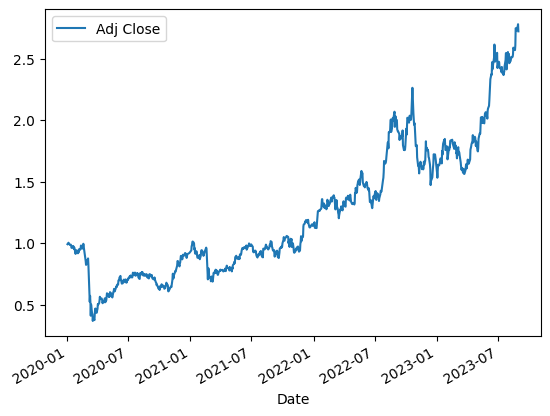

In [25]:
petr4_adj_retorno_acum.plot();

Sendo assim, devemo ter uma queda elevada no período do início de 2020 por conta da pandemia. Para determinarmos, nesse período entre 2020 e 2023 qual a maior queda, deveremos calcular o maior drawdown:

In [26]:
ponto_maximo = petr4_adj_retorno_acum.expanding(min_periods=1).max()
drawdown = (petr4_adj_retorno_acum/ponto_maximo)-1
maior_drawdown = drawdown.min()
maior_drawdown[0]

-0.6335606134051184

Aqui vemos que o maior drawdown (lê-se, maior queda da carteira) no período foi de 63,4%.
Pode ser interessante, para questões de análise de ativos, fazer a comparação desse drawdown com o ibovespa, que é o benchmark desse ativo. Como proxy, irei fazer a comparação com o drawdown do BOVA11.

[*********************100%***********************]  1 of 1 completed


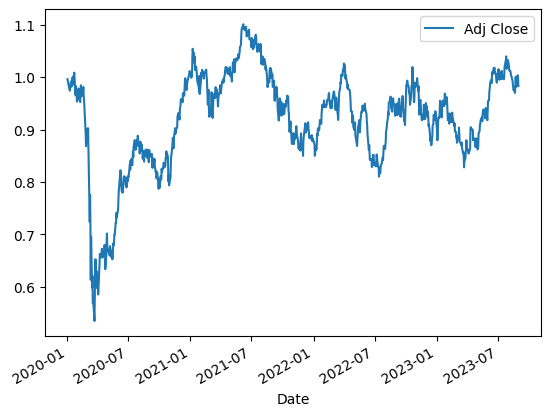

In [27]:
bova11 = yf.download('BOVA11.SA', start= '2020-01-01', end= '2023-09-01')[ 'Adj Close']
bova11 = bova11.to_frame()
bova11_retorno = bova11.pct_change()
bova11_retorno.dropna(inplace=True)
bova11_retorno_acum = (1 + bova11_retorno).cumprod()
bova11_retorno_acum.plot();

In [28]:
ponto_maximo_bova11 = bova11_retorno_acum.expanding(min_periods=1).max()
drawdown_bova11 = (bova11_retorno_acum/ponto_maximo_bova11)-1
maior_drawdown_bova11 = drawdown_bova11.min()
maior_drawdown_bova11[0]

-0.4693169006552963

A princípio, vemos que o mercado (no nosso caso, o BOVA11) apresenta um drawdon máximo de 46,9%. Ou seja, temos uma queda máxima maior em PETR4 do que no mercado.
Porém, vamos colocar os dois gráficos juntos para entendermos as diferenças.

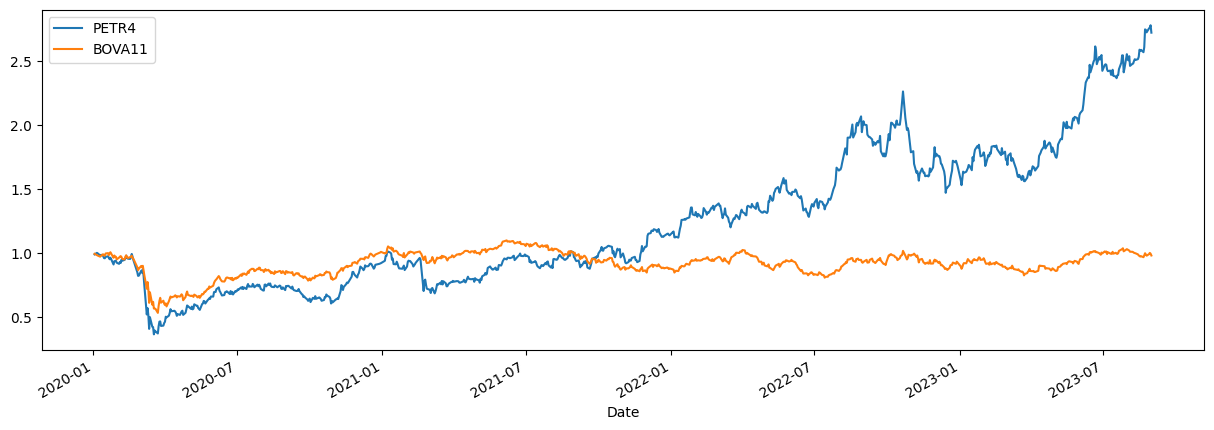

In [29]:

comp_petr4_bova11 = pd.merge(petr4_adj_retorno_acum.rename(columns={'Adj Close':'PETR4'}),
                            bova11_retorno_acum.rename(columns={'Adj Close':'BOVA11'}),
                            how = 'inner',
                            left_index = True,
                            right_index = True)
comp_petr4_bova11.plot(figsize=(15,5));

Apesar do BOVA11 ter um drawdown máximo menor do que a PETR4, ele apresenta um retorno bem mais baixo.

## 5.4. Índice de Calmar

Por fim, vamos analisar o Índice de Calmar. Esse índice também é uma variação do índice de Sharpe e, nesse novo caso, nós iremos considerar apenas o drawdown máximo do nosso ativo para avaliar o risco. Usualmente, essse é um índice mais utilizado para avaliar fundos, mas aqui estaremos utilizando em nosso ativo. Para isso, utilizaremos a equação:

\begin{equation}
Calmar=\frac{({R_i} - {R_f})}{|drawdown\hspace{0.1cm}máximo|}
\end{equation}

Portanto, calculamos:

In [30]:
calmar = (petr4_adj_retorno_anualizado[0]-selic)/abs(maior_drawdown[0])
calmar

0.5112802743607208

Seguindo o que já falamos no passado, temos então que o índice de Calmar é de aproximadamente 0,51. Esse valor não chega a 1, indicando que talvez esse investimento não seja ideal com uma selic tão alta.

# 6. Conclusão

Com todos os resultados encontrados, vemos que apesar do retorno elevado que o o ativo apresentou entre Janeiro de 2020 e Setembro de 2023, os seus indicadores de risco/retorno quando comparados com uma Selic mais elevada (8% a.a.), parecem pouco atrativos.

A decisão de investir ou não no ativo fica por conta do investidor, porém acredito que como os retornos do ativo mostram uma distribuição com assimetria negativa, alto retorno, e seu dradown máximo ter ocorrido por conta da externalidade do COVID-19, o investimento nesse ativo pode ser feito em conjunto com outros ativos de menor volatilidade, para balancear o risco apresentado e colher os rendimentos esperados.

Também é aconselhado um acompanhamento tempestivo dos movimentos desse ativo.